In [1]:
import torch
from VRP_Net_L import VRPNet_L
from matplotlib import pyplot as plt
import utils
import os
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import time
import LSE_net
from torch import optim
import importlib

In [2]:
importlib.reload(LSE_net)
lse_data = torch.load('logSumExp_models/lse_2025_5_19__15_47_58.pth', weights_only=False)
n_inputs = lse_data['n_inputs']
n_outputs = lse_data['n_outputs']
layers = lse_data['layers']
weights = lse_data['model_state_dict']
io_scale = lse_data['io_scale']
lse_net = LSE_net.dnn(n_inputs, n_outputs, layers)
# lse_net.to(device)
lse_net.load_state_dict(weights)
lse_net.eval()
for p in lse_net.parameters():
    p.requires_grad = False
print(f'n_inputs: {n_inputs}\nn_outputs: {n_outputs}\nlayers: {layers}\nio_scale: {io_scale}\nLSE_net:\n{summary(lse_net)}')

n_inputs: 3
n_outputs: 1
layers: [20, 20, 10]
io_scale: 1
LSE_net:
Layer (type:depth-idx)                   Param #
dnn                                      --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       (80)
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       (420)
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       (210)
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       (11)
Total params: 721
Trainable params: 0
Non-trainable params: 721


In [3]:
importlib.reload(utils)
# d_array = np.random.uniform(0.0, 5.0, 100)
d_min =  np.random.uniform(0.0, 3.0)
F_min = np.random.uniform(d_min, 5.0)
b_min = 1e-3
b_max = 2e5
b_grow = 1.01
b_arr = utils.createBetaArray(b_min, b_max, b_grow).view(-1,1)


In [4]:
F_min_arr = F_min * torch.ones(len(b_arr), dtype=torch.float32).view(-1,1)
d_min_arr = d_min * torch.ones(len(b_arr), dtype=torch.float32).view(-1,1).requires_grad_()
log_b_arr = torch.log(b_arr)/torch.log(torch.tensor([10]))
In = torch.cat((F_min_arr, d_min_arr, log_b_arr), axis=1).requires_grad_()
In

tensor([[ 4.6237,  1.2337, -3.0000],
        [ 4.6237,  1.2337, -2.9957],
        [ 4.6237,  1.2337, -2.9914],
        ...,
        [ 4.6237,  1.2337,  5.2927],
        [ 4.6237,  1.2337,  5.2970],
        [ 4.6237,  1.2337,  5.3014]], grad_fn=<CatBackward0>)

In [5]:
Out = lse_net(In)
Out


tensor([[4.6527],
        [4.6527],
        [4.6526],
        ...,
        [1.1886],
        [1.1886],
        [1.1886]], grad_fn=<AddmmBackward0>)

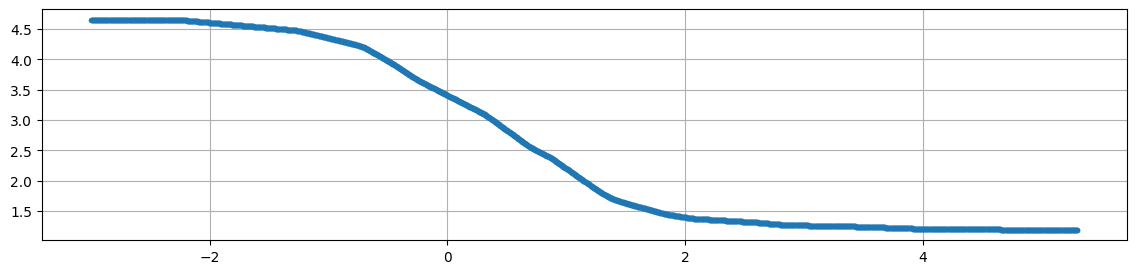

In [6]:
plt.figure(figsize=(14,3))
plt.plot(log_b_arr.numpy().flatten(), Out.detach().numpy().flatten(), marker='.')
plt.grid()
plt.show()

### Compute $\frac{\partial F}{\partial I}$ where $I = [F_{min}, d_{min}, \log_{10}\beta]$

In [7]:
gradient0 = torch.autograd.grad(outputs=Out, inputs=In, grad_outputs=torch.ones_like(Out), create_graph=True)
# gradient0

### Compute $\frac{\partial F}{\partial d_{min}}$ 

In [8]:
gradient1 = torch.autograd.grad(outputs=Out, inputs=d_min_arr,
                               grad_outputs=torch.ones_like(Out),
                               create_graph=True)
# gradient1

### Plot Gradients as a function of $\beta$

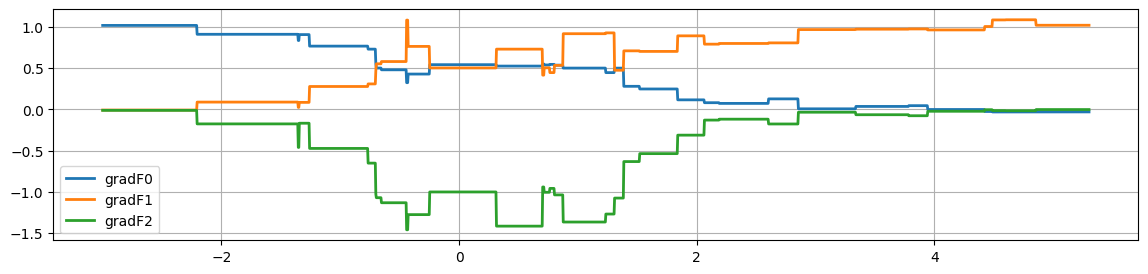

In [9]:
dFdI0 = gradient0[0].detach().numpy()[:,0]
dFdI1 = gradient0[0].detach().numpy()[:,1]
dFdI2 = gradient0[0].detach().numpy()[:,2]

plt.figure(figsize=(14,3))
plt.plot(log_b_arr.numpy().flatten(), dFdI0, label='gradF0', linestyle='solid', linewidth=2)#, marker='d')
plt.plot(log_b_arr.numpy().flatten(), dFdI1, label='gradF1', linestyle='solid', linewidth=2)#, marker='.')
plt.plot(log_b_arr.numpy().flatten(), dFdI2, label='gradF2', linestyle='solid', linewidth=2)#, marker='x')
plt.grid()
plt.legend()
plt.show()